In [1]:
import pandas as pd
import numpy as np
import gc
import lightgbm as lgb
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from sklearn import model_selection, dummy, metrics
import pickle

print(pd.__version__) #1.1.3
print(np.__version__) #1.19.4
print(sns.__version__) #0.11.0
print(matplotlib.__version__) # 3.3.2
print(sklearn.__version__) # 0.23.2

1.1.3
1.19.4
0.11.0
3.3.2
0.23.2


# Récupération des données

In [2]:
data = pd.read_csv("data/train_df.csv", index_col="index")
cat_features = pickle.load(open("pickle_cat_features.pkl", "rb"))

# Isolation de la cible et séparation des données (train, test)

In [3]:
X = data.drop(columns=['TARGET','SK_ID_CURR'])
y = data["TARGET"]
cat_features_index = np.where(X.columns.isin(cat_features))

del data
gc.collect()

20

In [4]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=123)

print(f"X_train : {X_train.shape}")
print(f"X_test : {X_test.shape}")
print(f"y_train : {y_train.shape}")
print(f"y_test : {y_test.shape}")

del X, y
gc.collect()

X_train : (246005, 676)
X_test : (61502, 676)
y_train : (246005,)
y_test : (61502,)


20

# Etablissement d'une baseline

In [5]:
# dummy classifier 
dummy_classifier = dummy.DummyClassifier(strategy="stratified", random_state=123)
dummy_classifier.fit(X_train,y_train)

DummyClassifier(random_state=123, strategy='stratified')

In [6]:
# performances
probas_pred = dummy_classifier.predict_proba(X_test)[:, 1]
p, r, _ = metrics.precision_recall_curve(y_test, probas_pred)
baseline = metrics.auc(r,p)
print(f"Baseline AUCPR par dummy classifier  : {baseline}")

del dummy_classifier
gc.collect()

Baseline AUCPR par dummy classifier  : 0.11880592645594451


40

# Entraînement d'un classifieur LightGBM sur le train set sur 5 folds (5 classifieurs)

In [7]:
# rectification des noms des features pour le classifieur LGBM

def replace_name(name):
    for c in ["[","]",",","{","}",'"',":"," "]:
        if c in name :
            name = name.replace(c,"_")
    return name
            
features = list(map(replace_name, X_train.columns))
X_train.columns = features
X_test.columns = features

In [8]:
# métrique LGBM personnalisée utilisant l'aire sous la courbe precision-recall (AUCPR)

def f_aucpr(y_true, probas_pred):
    
    p, r, _ = metrics.precision_recall_curve(y_true, probas_pred)
    score = metrics.auc(r,p)
    return "AUCPR", score, True

In [9]:
# modèle de cross validation pour entraînement par fold
folds = model_selection.StratifiedKFold(n_splits= 5, shuffle=True, random_state=123)

# création des dataframes pour stocker les résultats
oof_preds = np.zeros(X_train.shape[0])
sub_preds = np.zeros(X_test.shape[0])
feature_importance_df = pd.DataFrame()

for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_train, y_train)):
    train_x, train_y = X_train.iloc[train_idx], y_train.iloc[train_idx]
    valid_x, valid_y = X_train.iloc[valid_idx], y_train.iloc[valid_idx]

    # paramètres déterminés par optimisation Bayésienne
    clf = lgb.LGBMClassifier(
        n_jobs=-1,
        n_estimators=10000,
        learning_rate=0.02,
        num_leaves=37,
        colsample_bytree=0.1626780977682063,
        subsample=0.9061817454792065,
        max_depth=5,
        reg_alpha=0.8515028010996651,
        reg_lambda=0.5421869781111216,
        min_split_gain=0.021063972265591233,
        min_child_weight=29.09287622047518,
        silent=-1,
        verbose=-1,
        random_state=123,
        categorical_feature=list(cat_features_index[0]))
    
    
    # entraînement de chaque fold
    clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
        eval_metric=f_aucpr, verbose= 200, early_stopping_rounds= 200)

    # stockage des prédictions
    oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
    sub_preds += clf.predict_proba(X_test, num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits
    
    # stockage des features importances
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = X_train.columns
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    _, score, _ = f_aucpr(valid_y, oof_preds[valid_idx])
    print('Fold %2d AUCPR : %.6f' % (n_fold + 1, score))
    del clf, train_x, train_y, valid_x, valid_y
    gc.collect()


/home/samuel/.local/lib/python3.8/site-packages/lightgbm/basic.py:1075: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  warnings.warn('{0} keyword has been found in `params` and will be ignored.\n'


Training until validation scores don't improve for 200 rounds
[200]	training's binary_logloss: 0.241213	training's AUCPR: 0.302481	valid_1's binary_logloss: 0.245612	valid_1's AUCPR: 0.264616
[400]	training's binary_logloss: 0.230647	training's AUCPR: 0.33594	valid_1's binary_logloss: 0.23904	valid_1's AUCPR: 0.279485
[600]	training's binary_logloss: 0.224771	training's AUCPR: 0.361489	valid_1's binary_logloss: 0.236785	valid_1's AUCPR: 0.286548
[800]	training's binary_logloss: 0.220562	training's AUCPR: 0.381801	valid_1's binary_logloss: 0.235784	valid_1's AUCPR: 0.289498
[1000]	training's binary_logloss: 0.217292	training's AUCPR: 0.399024	valid_1's binary_logloss: 0.235213	valid_1's AUCPR: 0.291028
[1200]	training's binary_logloss: 0.214335	training's AUCPR: 0.415299	valid_1's binary_logloss: 0.234814	valid_1's AUCPR: 0.292162
[1400]	training's binary_logloss: 0.211546	training's AUCPR: 0.431226	valid_1's binary_logloss: 0.234604	valid_1's AUCPR: 0.292541
[1600]	training's binary_lo

Fold  5 AUCPR : 0.284166


In [10]:
# affichage des performances

_, train_score, _ = f_aucpr(y_train, oof_preds)
_, test_score, _ = f_aucpr(y_test, sub_preds)
print(f"AUCPR sur train set  : {train_score}")
print(f"AUCPR sur test set : {test_score}")

AUCPR sur train set  : 0.2837622413411899
AUCPR sur test set : 0.2939693857112788


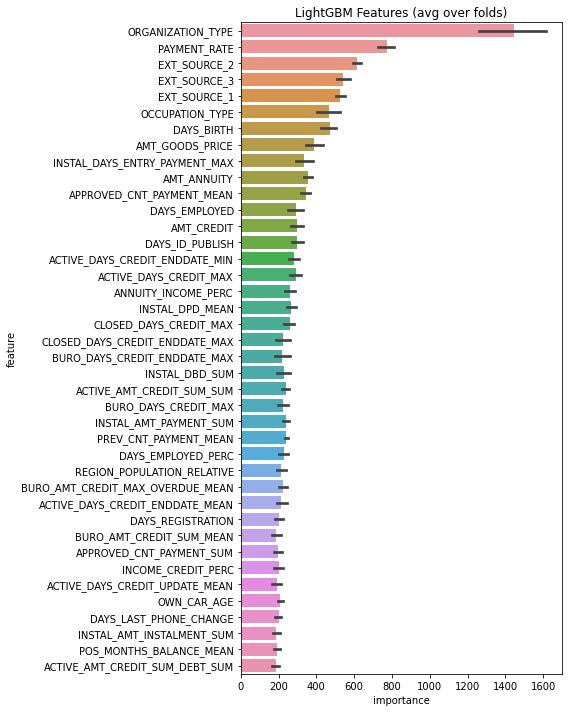

In [11]:
# affichage de l'importance des features

cols = feature_importance_df[["feature", "importance"]].groupby("feature").mean()\
                    .sort_values(by="importance", ascending=False)[:40].index
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]
plt.figure(figsize=(8, 10))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('img/lgbm_importances01.png')

# Entraînement d'un LGBM Classifier unique sur le train set

In [12]:
# création d'un set de validation

train_x, valid_x, train_y, valid_y = model_selection.train_test_split(X_train, y_train, test_size=0.2, 
                                                                      random_state=123)

In [13]:
# modèle avec les mêmes paramètres

clf = lgb.LGBMClassifier(
        n_jobs=-1,
        n_estimators=10000,        
        learning_rate=0.02,
        num_leaves=37,
        colsample_bytree=0.1626780977682063,
        subsample=0.9061817454792065,
        max_depth=5,
        reg_alpha=0.8515028010996651,
        reg_lambda=0.5421869781111216,
        min_split_gain=0.021063972265591233,
        min_child_weight=29.09287622047518,
        silent=-1,
        verbose=-1,
        random_state=123,
        categorical_feature=list(cat_features_index[0]))

# entraînement
clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
    eval_metric=f_aucpr, verbose= 200, early_stopping_rounds= 200)

/home/samuel/.local/lib/python3.8/site-packages/lightgbm/basic.py:1075: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  warnings.warn('{0} keyword has been found in `params` and will be ignored.\n'


Training until validation scores don't improve for 200 rounds
[200]	training's binary_logloss: 0.239787	training's AUCPR: 0.307701	valid_1's binary_logloss: 0.249682	valid_1's AUCPR: 0.24902
[400]	training's binary_logloss: 0.229188	training's AUCPR: 0.342148	valid_1's binary_logloss: 0.243948	valid_1's AUCPR: 0.262076
[600]	training's binary_logloss: 0.223358	training's AUCPR: 0.367448	valid_1's binary_logloss: 0.242127	valid_1's AUCPR: 0.266894
[800]	training's binary_logloss: 0.219115	training's AUCPR: 0.388071	valid_1's binary_logloss: 0.241244	valid_1's AUCPR: 0.269394
[1000]	training's binary_logloss: 0.215645	training's AUCPR: 0.40624	valid_1's binary_logloss: 0.240718	valid_1's AUCPR: 0.270969
[1200]	training's binary_logloss: 0.212815	training's AUCPR: 0.421475	valid_1's binary_logloss: 0.240391	valid_1's AUCPR: 0.272394
[1400]	training's binary_logloss: 0.210206	training's AUCPR: 0.436335	valid_1's binary_logloss: 0.240215	valid_1's AUCPR: 0.272787
[1600]	training's binary_lo

LGBMClassifier(categorical_feature=[0, 1, 2, 3, 9, 10, 11, 12, 13, 26, 30, 38,
                                    84, 85, 87, 88, 120],
               colsample_bytree=0.1626780977682063, learning_rate=0.02,
               max_depth=5, min_child_weight=29.09287622047518,
               min_split_gain=0.021063972265591233, n_estimators=10000,
               num_leaves=37, random_state=123, reg_alpha=0.8515028010996651,
               reg_lambda=0.5421869781111216, silent=-1,
               subsample=0.9061817454792065, verbose=-1)

In [14]:
# performances

y_pred = clf.predict_proba(X_test, num_iteration=clf.best_iteration_)[:, 1]
f_aucpr(y_test, y_pred)

('AUCPR', 0.28876832195828184, True)

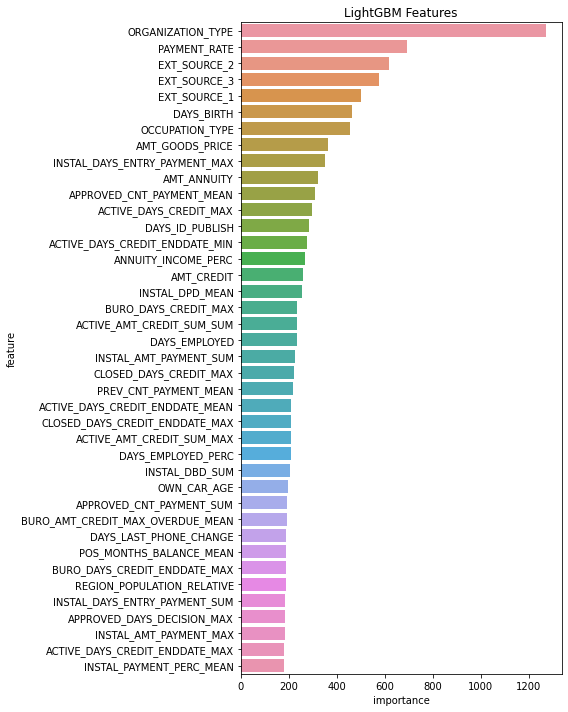

In [15]:
# features importances

feature_importance_df = pd.DataFrame()
feature_importance_df["feature"] = X_train.columns
feature_importance_df["importance"] = clf.feature_importances_
best_features_idx = feature_importance_df.sort_values(by="importance", ascending=False)[:40].index
plt.figure(figsize=(8, 10))
sns.barplot(x="importance", y="feature", data=feature_importance_df.iloc[best_features_idx].sort_values(by="importance", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()

Les performances sont à peine moins bonnes, je garde donc ce principe d'un classifieur unique.


In [16]:
# AUROC du modèle

print(metrics.roc_auc_score(y_test, y_pred))


0.7916168215408249


In [17]:
# recherche du seuil optimisant le f1-score

for thres in np.linspace(0.1,0.19,10):
    y_pred_label = [0 if i<=thres else 1 for i in y_pred]
    score = metrics.f1_score(y_test,y_pred_label)
    print(f"Seuil {thres} f1-score {score}")

Seuil 0.1 f1-score 0.31409489633173837
Seuil 0.11 f1-score 0.32328737260886153
Seuil 0.12000000000000001 f1-score 0.3320504470365327
Seuil 0.13 f1-score 0.3365335381464413
Seuil 0.14 f1-score 0.34040508067284586
Seuil 0.15000000000000002 f1-score 0.3425089921456361
Seuil 0.16 f1-score 0.343375851005556
Seuil 0.17 f1-score 0.3433021290696711
Seuil 0.18 f1-score 0.34359153698198985
Seuil 0.19 f1-score 0.34100957995578485


In [19]:
# rapport de performances 

thres = 0.18
y_pred_label = [0 if i<=thres else 1 for i in y_pred]
print(metrics.classification_report(y_test, y_pred_label, digits=4))
print(metrics.confusion_matrix(y_test, y_pred_label))

              precision    recall  f1-score   support

         0.0     0.9457    0.9201    0.9327     56547
         1.0     0.3031    0.3966    0.3436      4955

    accuracy                         0.8779     61502
   macro avg     0.6244    0.6583    0.6381     61502
weighted avg     0.8939    0.8779    0.8852     61502

[[52029  4518]
 [ 2990  1965]]
